In [5]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)

#!pip install shap

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()  ## input type err solved
from tensorflow.keras.models import load_model
from keras.utils.np_utils import to_categorical
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM, Dropout
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.metrics import Recall, Precision  ##, F1Score
##https://stackoverflow.com/questions/66814523/shap-deepexplainer-with-tensorflow-2-4-error?noredirect=1
## this might be helpful your debugging!!!
import shap
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from model_team14 import *
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report

In [7]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
path='drive/MyDrive/Capstone(Team10)/code'

#file = tf.keras.utils
with open(path+'/data/X_data.pkl','rb') as f:
  X_data=pickle.load(f)

with open(path+'/data/y_data.pkl','rb') as f:
  y_data=pickle.load(f)

with open(path+'/data/selected_features.pkl','rb') as f:
  selected_features=pickle.load(f)

metadata=pd.read_csv(path+'/data/metadata_final.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
## manually assign value
model_name='clf_lstm_y_nber_24_b6_ep30_h10'

y_type = model_name.split('_')[2]+'_'+model_name.split('_')[3]
test_year=5
time_step=int(model_name.split('_')[4])
batch_size=int(model_name.split('_')[5][1:])
num_epochs=int(model_name.split('_')[6][2:])
num_layer=int(model_name.split('_')[7][1:])
metrics=['AUC','Accuracy','Recall','Precision']

if y_type=='y_agg':
    num_classes=3
else:
    num_classes=2

print(y_type, ' time step:', time_step, ' batch size:', batch_size, ' #epoch:', num_epochs, ' #class:', num_classes, ' num_layer:', num_layer)

y_nber  time step: 24  batch size: 6  #epoch: 30  #class: 2  num_layer: 10


In [9]:
# import function_team10
# from function_team10 import *

In [10]:
## time_step means the length(n) of explanatory variables(t-(n-1) ~ t) to use for classifying y in certain time(t) period.

import tensorflow as tf
from tensorflow import keras

import os
import tempfile
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Recall, Precision

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []

    if type(Xs)==pd.core.frame.DataFrame:
      for i in range(len(X) - time_steps):
          v = X.iloc[i:(i + time_steps)].values
          Xs.append(v)
          ys.append(y.iloc[i + time_steps].values)
          Xs=np.array(Xs)
          ys=np.array(ys)

    else:
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])

    return np.array(Xs), np.array(ys)

def make_model(num_layer, X_train, nc, metrics, loss_type):
    model = Sequential()
    model.add(LSTM(num_layer, input_shape=(X_train.shape[1], X_train.shape[2])))  ##input_shape=(X_train.shape[1], X_train.shape[2])
    # model.add(Dropout(0.2))
    #model.add(Dense(2))
    model.add(Dense(nc, activation='sigmoid'))
    model.compile(loss=loss_type, optimizer='adam', metrics=metrics)  ##['AUC','Accuracy','Recall','Precision','F1Score']
    return model

In [12]:
## whole train dataset
X_train=X_data.iloc[:-test_year*12]
y_train=y_data.iloc[:-test_year*12]
X_test=X_data.iloc[-test_year*12:]
y_test=y_data.iloc[-test_year*12:]

## standard scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## make timestep
trainx, trainy = create_dataset(X_train, y_train, time_step)
testx, testy = create_dataset(X_test, y_test, time_step)
trainy = to_categorical(trainy, num_classes=num_classes)
testy = to_categorical(testy, num_classes=num_classes)

## calculate class weight
neg, pos = np.bincount(y_train)
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

# create the model weighting more for class 1 & train the model
#final_model=make_model(num_layer, trainx, num_classes, metrics, 'categorical_crossentropy')
final_model=load_model(path+'/model/{}.h5'.format(model_name), compile=False)
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC','Accuracy','Recall', 'Precision'])

history=final_model.fit(trainx, trainy, epochs=num_epochs, batch_size=batch_size, class_weight=class_weight)

## generate shap explainer and calculate shap values
explainer=shap.DeepExplainer(final_model, trainx)
values_test=explainer.shap_values(np.array(testx))
values_train=explainer.shap_values(np.array(trainx))

Train on 516 samples
Epoch 1/30
516/516 [==============================] - 3s 5ms/sample - loss: 0.4138 - auc: 0.9207 - accuracy: 0.0000e+00 - recall: 0.8488 - precision: 0.8813
Epoch 2/30
516/516 [==============================] - 2s 3ms/sample - loss: 0.2041 - auc: 0.9517 - accuracy: 0.0000e+00 - recall: 0.8527 - precision: 0.9322
Epoch 3/30
516/516 [==============================] - 2s 4ms/sample - loss: 0.1518 - auc: 0.9706 - accuracy: 0.0000e+00 - recall: 0.8721 - precision: 0.9615
Epoch 4/30
516/516 [==============================] - 1s 2ms/sample - loss: 0.1240 - auc: 0.9777 - accuracy: 0.0000e+00 - recall: 0.9167 - precision: 0.9693
Epoch 5/30
516/516 [==============================] - 1s 3ms/sample - loss: 0.1376 - auc: 0.9728 - accuracy: 0.0000e+00 - recall: 0.9128 - precision: 0.9515
Epoch 6/30
516/516 [==============================] - 1s 3ms/sample - loss: 0.1174 - auc: 0.9811 - accuracy: 0.0000e+00 - recall: 0.9167 - precision: 0.9536
Epoch 7/30
516/516 [=================

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



## Interpretation for LSTM shap values

* shap values.shape=(label, #sample, time-step, #features)

* each element in shap values[label][time] represent the contribution of "each feature at timestep" to the predicted probability of label at specific time (refer to https://www.kaggle.com/code/ltsmssv/shap-for-lstm-hpccv2)

* for label k at time t:
> shap_values[k][i].sum() + base probability for the label(=explainer.expected_value[k]) = predicted prob for label k at time t
> therefore (m,n) element of shap_values[k][i] means the effect of nth feature at mth time-step in unit of probability of label k for time t.
> In detail, if the element is 0.03, it means that nth feature at mth time-step increase the probabiliy of being label k at time t by +0.03(3%p).


### figuring out the most important features for predicting test-set as label=k ( as an average level for test-set periods)
* for label k at time t: calculate the percentage of each feature in change from base probability
* for each feature, average the above values across all time periods.
* output shape=(#features,)


### figuring out the importance and effect of features for predicting test-set as label=k at t=t
* for label k at time t: for each feature, sum shap_values across all time-steps
* output shape=(#feautures,)


### figuring out the importance and effect of time-step for predicting test-set as label=k at t=i
* for label k at time t: for each time-step, sum shap_values across all features
* output shape=(#time-steps,)

## Feature Importance(Overall) for training/test set

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


['Production Construction Total construction Total', 'Sales Retail trade Total retail trade Value', 'Real personal income excluding current transfer receipts', 'S&P 500 index', 'WTI spot price']


<BarContainer object of 5 artists>

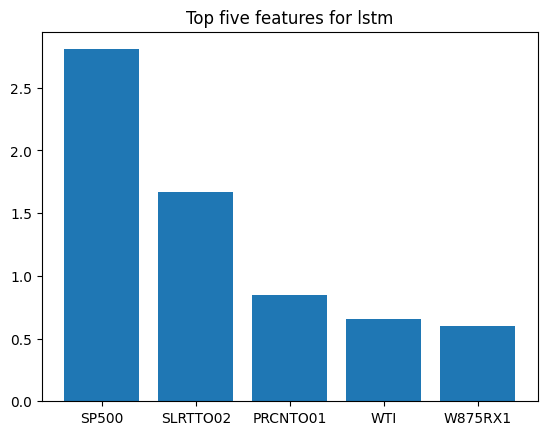

In [13]:
## ****** assign label here! ***********//
label=1
version='test' ## 'train' or 'test'
##############################################################

if version=='train':
    values=values_train
    x=trainx
else:
    values=values_test
    x=testx

ft_imp=np.zeros(len(selected_features))  #number of features
length=values[label].shape[0]      ##time period length

## calculate percentage of each features for change from base_level at each time
## average across time

y_pred_prob=final_model.predict(x)

for t in range(length):
    value_ft=np.sum(values[label][t], axis=0)
    denominator=(y_pred_prob[:,label][t]-explainer.expected_value[label])
    ft_imp+=value_ft/value_ft.sum()

ft_imp=ft_imp/length

df=pd.DataFrame({'feature':selected_features, 'ft_imp':ft_imp}).sort_values('ft_imp', ascending=False)[:5]

ft_names=metadata[metadata.SUBJECT.isin(df.feature)]['Name']

print(list(ft_names))

plt.title('Top five features for lstm')
plt.bar(df.feature, df.ft_imp)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


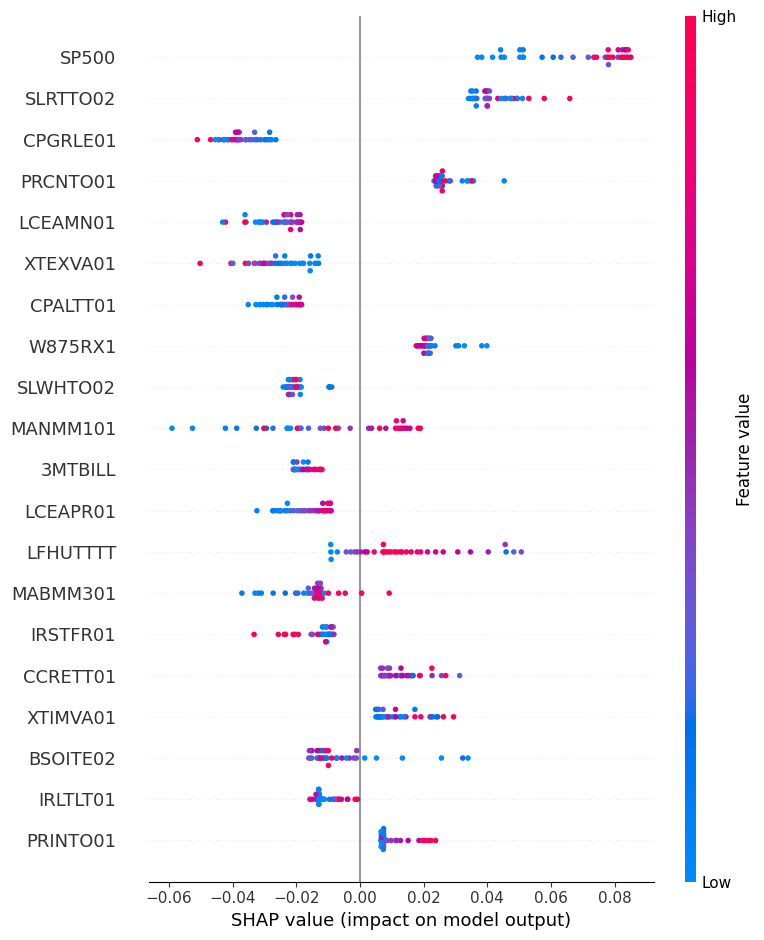

In [14]:
## ****** assign here! ***********//
label=1
version='test' ## 'train' or 'test'
##############################################################

if version=='train':
    values=values_train
    x=trainx
else:
    values=values_test
    x=testx

## reduce dimension of (sample * timestep * features) ==> (sample * features)
## for shap_values, sum across timesteps
## for feature value, average across timesteps
shap.summary_plot(np.sum(values, axis=2)[label], np.mean(x, axis=1), selected_features)

## Feature Importance Dependence Plot=PDP(global interpretability)

In [ ]:
selected_features

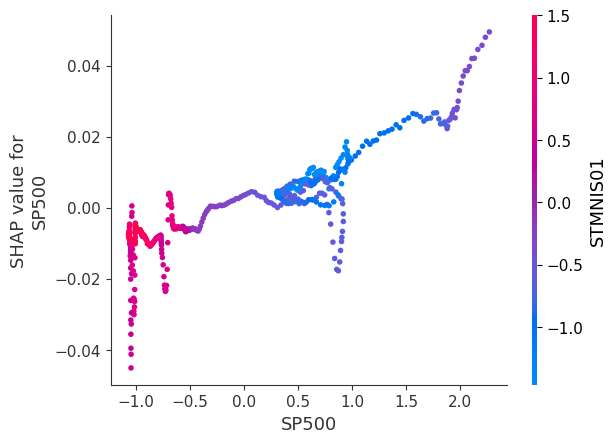

In [16]:
## ****** assign here! ***********//
label=1
variable='SP500'
version='train' ## 'train' or 'test'
##############################################################

var_idx=selected_features.index(variable)

if version=='train':
    values=values_train
    x=trainx
else:
    values=values_test
    x=testx

## reduce dimension of (sample * timestep * features) ==> (sample * features)
## for shap_values, sum across timesteps
## for feature value, average across timesteps
fig, ax=plt.subplots()
shap.dependence_plot(var_idx, np.sum(values, axis=2)[label], np.mean(x, axis=1), feature_names=selected_features, ax=ax)

## Features Importance(at certain time period)

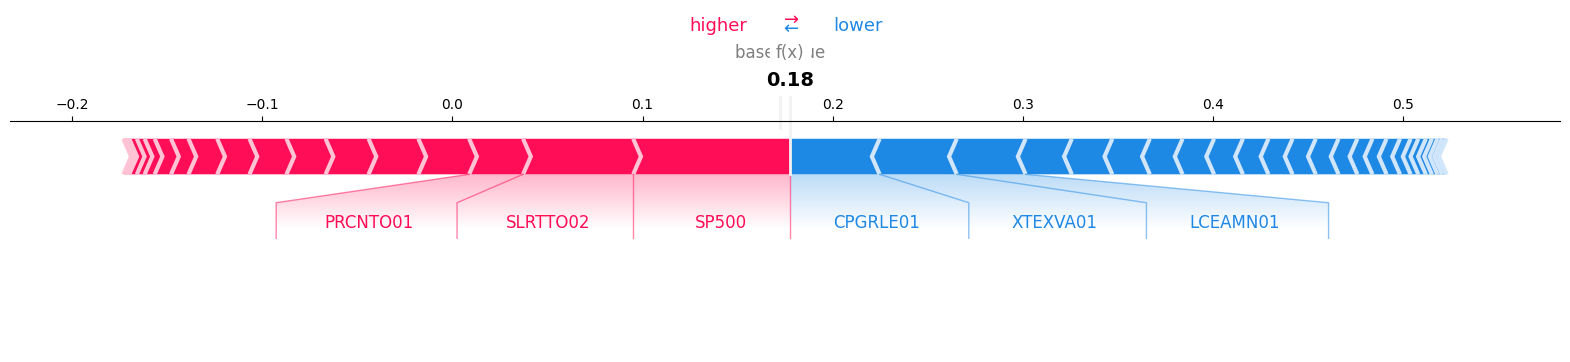

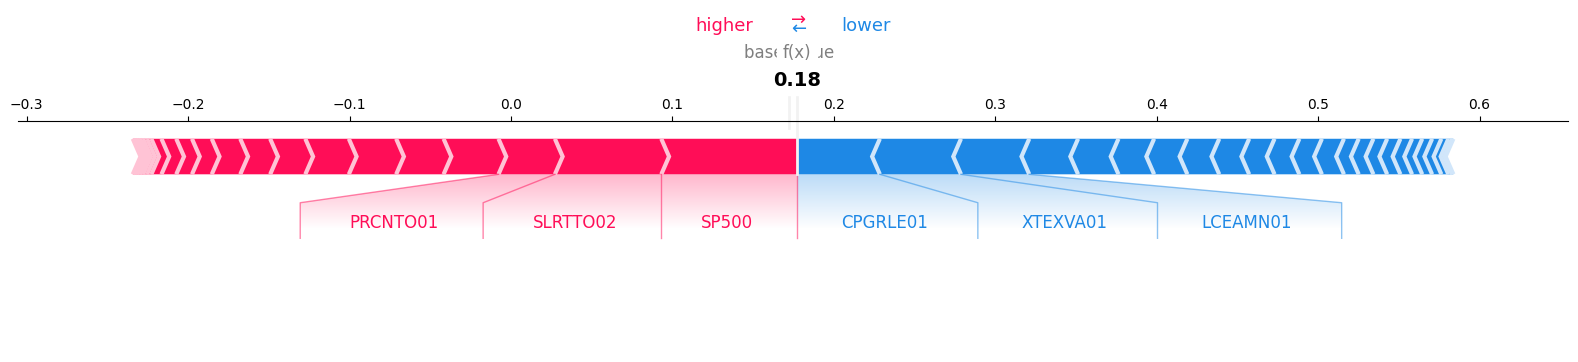

In [17]:
## ****** assign here! ***********//
label=1
version='test' ## 'train' or 'test'
t_list=[-2, -1]
##############################################################

if version=='train':
    values=values_train
else:
    values=values_test

for t in t_list:
    value_ft_t=np.sum(values[label][t], axis=0)
    shap.initjs()
    shap.force_plot(explainer.expected_value[label], value_ft_t, selected_features, matplotlib=True)

## Timestep Importance(at certain time period)

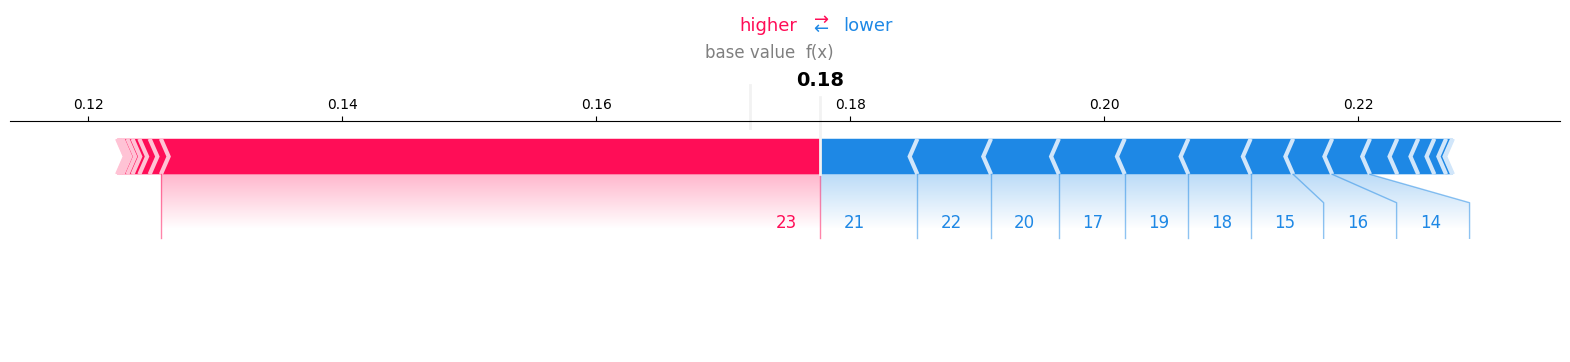

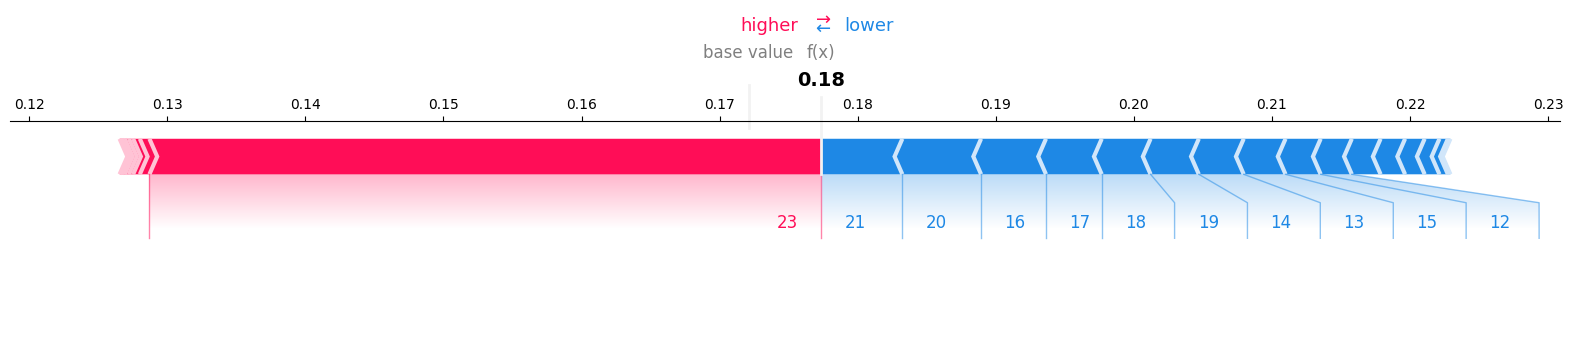

In [19]:
## ****** assign here! ***********//
label=1
version='test' ## 'train' or 'test'
t_list=[-2, -1]
##############################################################

ts_list=list(range(time_step))
if version=='train':
    values=values_train
else:
    values=values_test

for t in t_list:
    value_ts_t=np.sum(values[label][t], axis=1)
    shap.initjs()
    shap.force_plot(explainer.expected_value[label], value_ts_t, ts_list, matplotlib=True)

## Error Analysis & Feature Importance

### Let's see confusion matrix first

In [20]:
# Confusion Matrix

y_pred_prob=final_model.predict(testx)
y_pred=final_model.predict(testx).argmax(axis=1)
y_test=testy.argmax(axis=1)

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[34  0]
 [ 2  0]]


<Axes: >

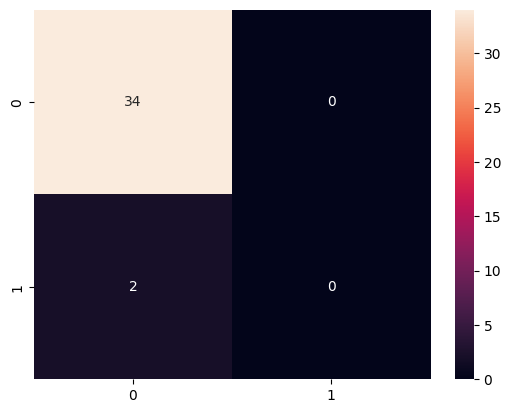

In [21]:
sns.heatmap(cf_matrix, annot=True)

<Axes: >

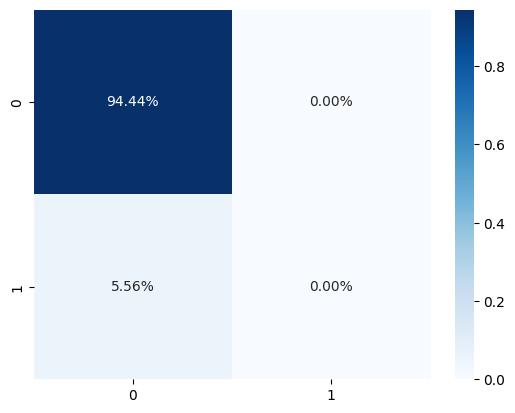

In [22]:
# Showing percentage of data represented in each quadrant
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.2%', cmap='Blues')

### Let's draw feature importance force plot for each error case

In [23]:
true_label=0
false_label=1

## calculate error time period list
err_idxs=np.argwhere((y_pred==false_label)&(y_test==true_label)).flatten() ## 1인데, 0으로 예측한 t지점들

## for each error time period, draw force_plot in terms of features
value_ft=np.sum(values_test[label][t], axis=0)

for err_t in err_idxs:
    value_ft=np.sum(values_test[true_label][err_t], axis=0)
    shap.initjs()
    shap.force_plot(explainer.expected_value[true_label], value_ft, selected_features, matplotlib=True)

### Let's draw time-step importance force plot for each error case

In [24]:
true_label=0
false_label=1

## calculate error time period list
ts_list=list(range(time_step))
err_idxs=np.argwhere((y_pred==false_label)&(y_test==true_label)).flatten()

## for each error time period, draw force_plot in terms of time steps
for err_t in err_idxs:
    value_ts=np.sum(values_test[true_label][err_t], axis=1)
    shap.initjs()
    shap.force_plot(explainer.expected_value[true_label], value_ts, ts_list, matplotlib=True)

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        34
           1       0.00      0.00      0.00         2

    accuracy                           0.94        36
   macro avg       0.47      0.50      0.49        36
weighted avg       0.89      0.94      0.92        36



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
